In [51]:
!pip install numpy tensorflow scikit-learn matplotlib seaborn opencv-python pillow


In [50]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report
from google.colab import drive
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline


In [ ]:
from google.colab import files
files.upload()  # upload kaggle.json

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download grassknoted/asl-alphabet
!unzip asl_alphabet.zip

In [47]:
import os
import shutil
import random
from glob import glob

# Make sure we’re working in Colab’s main directory
os.chdir('/content/')

# Base directories
SRC_DIR = '/content/data/asl_alphabet_train/asl_alphabet_train'
BASE_DIR = '/content/asl_split'  # New split output folder

# Split ratios
valid_ratio = 0.1
test_ratio  = 0.1

# Optional: make results reproducible
random.seed(42)

# --- 1️⃣ Clean previous output if it exists ---
if os.path.exists(BASE_DIR):
    shutil.rmtree(BASE_DIR)
os.makedirs(BASE_DIR, exist_ok=True)

# --- 2️⃣ Create destination folder structure ---
for split in ['train', 'valid', 'test']:
    for label in os.listdir(SRC_DIR):
        os.makedirs(os.path.join(BASE_DIR, split, label), exist_ok=True)

# --- 3️⃣ Split and copy files ---
for label in os.listdir(SRC_DIR):
    class_dir = os.path.join(SRC_DIR, label)
    files = glob(os.path.join(class_dir, '*.jpg'))
    random.shuffle(files)

    valid_end = int(len(files) * valid_ratio)
    test_end  = valid_end + int(len(files) * test_ratio)

    # Copy files to each split
    for f in files[:valid_end]:
        shutil.copy(f, os.path.join(BASE_DIR, 'valid', label))
    for f in files[valid_end:test_end]:
        shutil.copy(f, os.path.join(BASE_DIR, 'test', label))
    for f in files[test_end:]:
        shutil.copy(f, os.path.join(BASE_DIR, 'train', label))

print("✅ Safe copy complete!")
print(f"New split folders created at: {BASE_DIR}")


✅ Safe copy complete!
New split folders created at: /content/asl_split


In [61]:
os.chdir('asl_split')

In [62]:
train_newdata = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.25,
    horizontal_flip=False,
    fill_mode='nearest'
)

valid_newdata = ImageDataGenerator(rescale=1./255)
test_newdata  = ImageDataGenerator(rescale=1./255)


train_generator = train_newdata.flow_from_directory(
    'train',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_newdata.flow_from_directory(
    'valid',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)




Found 69600 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.


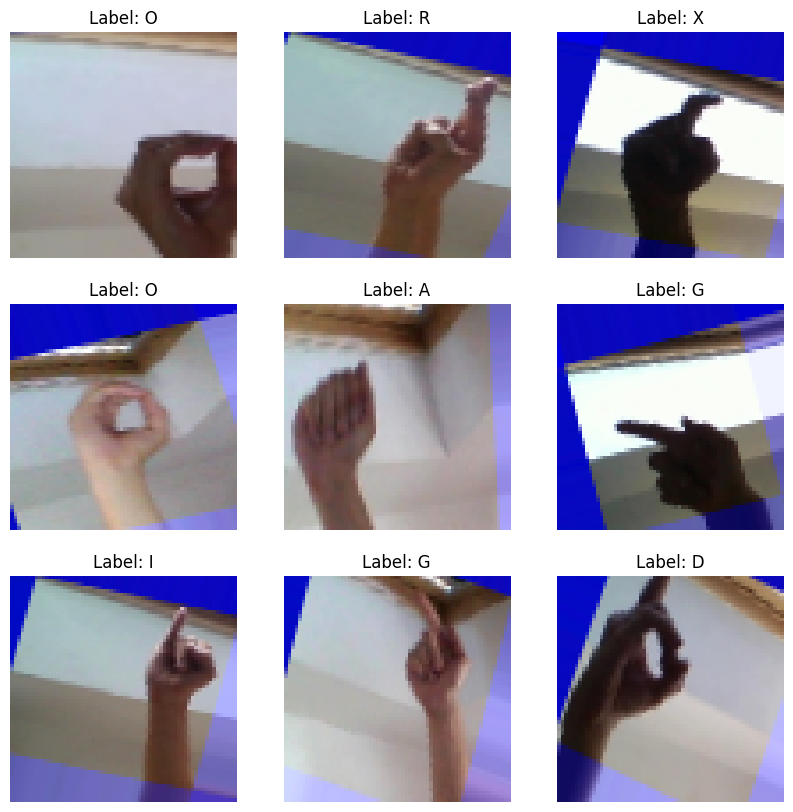

In [63]:
x_batch, y_batch = next(train_generator)
labels = list(train_generator.class_indices.keys())

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_batch[i])
    plt.axis('off')
    plt.title(f"Label: {labels[np.argmax(y_batch[i])]}")
plt.show()


In [64]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(64, 64, 3)
)
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(29, activation='softmax')  # 29 ASL classes
])

/tmp/ipython-input-1555464441.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [65]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [66]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator
)


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2175/2175 ━━━━━━━━━━━━━━━━━━━━ 181s 75ms/step - accuracy: 0.3255 - loss: 2.3524 - val_accuracy: 0.6523 - val_loss: 1.1413
Epoch 2/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 149s 68ms/step - accuracy: 0.5225 - loss: 1.5532 - val_accuracy: 0.6826 - val_loss: 1.0234
Epoch 3/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 151s 69ms/step - accuracy: 0.5547 - loss: 1.4293 - val_accuracy: 0.7031 - val_loss: 0.9525
Epoch 4/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 156s 72ms/step - accuracy: 0.5715 - loss: 1.3767 - val_accuracy: 0.7015 - val_loss: 0.9383
Epoch 5/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 150s 69ms/step - accuracy: 0.5840 - loss: 1.3240 - val_accuracy: 0.7087 - val_loss: 0.9091
Epoch 6/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 151s 69ms/step - accuracy: 0.5915 - loss: 1.3041 - val_accuracy: 0.7140 - val_loss: 0.9048
Epoch 7/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 152s 70ms/step - accuracy: 0.6019 - loss: 1.2703 - val_accuracy: 0.7102 - val_loss: 0.8891
Epoch 8/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 155s 71ms/step - accuracy: 0.6112 - lo

In [67]:
for layer in base_model.layers[-20:]:
    layer.trainable = True


model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [68]:
history_fine = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=5
)

Epoch 1/5
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 176s 74ms/step - accuracy: 0.2803 - loss: 4.1985 - val_accuracy: 0.5597 - val_loss: 1.4704
Epoch 2/5
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 153s 70ms/step - accuracy: 0.3979 - loss: 2.1382 - val_accuracy: 0.5923 - val_loss: 1.2847
Epoch 3/5
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 155s 71ms/step - accuracy: 0.4771 - loss: 1.7451 - val_accuracy: 0.6454 - val_loss: 1.0831
Epoch 4/5
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 155s 71ms/step - accuracy: 0.5453 - loss: 1.4952 - val_accuracy: 0.7038 - val_loss: 0.9027
Epoch 5/5
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 154s 71ms/step - accuracy: 0.5780 - loss: 1.3502 - val_accuracy: 0.7429 - val_loss: 0.7738


In [69]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        'test',
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical')

test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Found 8700 images belonging to 29 classes.
  3/271 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.7396 - loss: 0.7819 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


271/271 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.7471 - loss: 0.7578
Test loss: 0.7615951895713806
Test accuracy: 0.7481549978256226


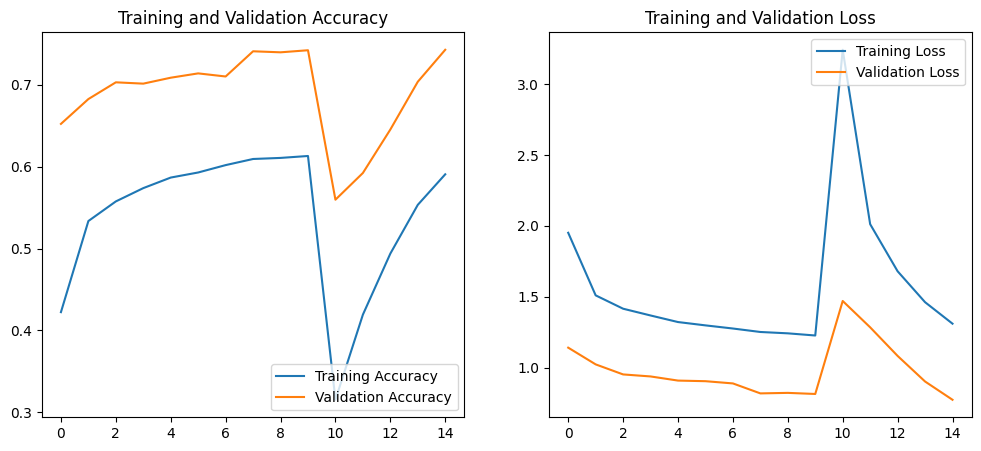

In [70]:
def plot_history(hist1, hist2):
    acc = hist1.history['accuracy'] + hist2.history['accuracy']
    val_acc = hist1.history['val_accuracy'] + hist2.history['val_accuracy']
    loss = hist1.history['loss'] + hist2.history['loss']
    val_loss = hist1.history['val_loss'] + hist2.history['val_loss']

    epochs_range = range(len(acc))
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history, history_fine)

In [71]:
model.save('asl_model_v2.keras')


In [75]:
files.download('/content/asl_split/asl_model_v2.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import gradio as gr
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from PIL import Image

MODEL_PATH = ""
IMG_SIZE = (64, 64)

try:
    model = load_model(MODEL_PATH)
    print("Model loaded successfully")
    print("Model input shape:", model.input_shape)
    print("Model output shape:", model.output_shape)
except Exception as e:
    print(f"Error loading model: {e}")
    model = None

class_labels = [
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
    'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S',
    'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space'
]
def predict_asl(img):
    if model is None:
        return {"Error: model not loaded": 1.0}
    if img is None:
        return {"Error: no image": 1.0}

    try:
        expected_channels = model.input_shape[-1]
        if expected_channels == 1:
            img = img.convert("L")
        else:
            img = img.convert("RGB")
        img = img.resize(IMG_SIZE)
        arr = image.img_to_array(img)
        arr = np.expand_dims(arr, axis=0)
        arr = arr.astype("float32")
        if arr.max() > 1.0:
            arr /= 255.0
        preds = model.predict(arr, verbose=0)
        probs = preds[0]
        if probs.sum() < 0.99 or probs.sum() > 1.01:
            exp = np.exp(probs - np.max(probs))
            probs = exp / np.sum(exp)
        top_indices = np.argsort(probs)[-3:][::-1]
        results = {class_labels[i]: float(probs[i]) for i in top_indices}
        return results
    except Exception as e:
        print("Prediction error:", e)
        return {"Error": 1.0, "Message": str(e)}
demo = gr.Interface(
    fn=predict_asl,
    inputs=gr.Image(
        sources=["webcam", "upload"],
        type="pil",
        label="Take or upload an ASL hand sign"
    ),
    outputs=gr.Label(
        num_top_classes=3,
        label="Predicted ASL Letter"
    ),
    title="ASL Hand Sign Classifier",
    description="Take or upload a photo of an ASL hand sign to predict the letter.",
    theme=gr.themes.Soft()
)

if __name__ == "__main__":
    demo.launch(
        share=True,
        inbrowser=True,
        debug=True,
        show_error=True
    )
